In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from sklearn import datasets

In [3]:
dataset = datasets.load_iris()

In [4]:
print(dataset['DESCR'])

.. _iris_dataset:

Iris plants dataset
--------------------

**Data Set Characteristics:**

    :Number of Instances: 150 (50 in each of three classes)
    :Number of Attributes: 4 numeric, predictive attributes and the class
    :Attribute Information:
        - sepal length in cm
        - sepal width in cm
        - petal length in cm
        - petal width in cm
        - class:
                - Iris-Setosa
                - Iris-Versicolour
                - Iris-Virginica
                
    :Summary Statistics:

    ============== ==== ==== ======= ===== ====================
                    Min  Max   Mean    SD   Class Correlation
    ============== ==== ==== ======= ===== ====================
    sepal length:   4.3  7.9   5.84   0.83    0.7826
    sepal width:    2.0  4.4   3.05   0.43   -0.4194
    petal length:   1.0  6.9   3.76   1.76    0.9490  (high!)
    petal width:    0.1  2.5   1.20   0.76    0.9565  (high!)
    ============== ==== ==== ======= ===== ===========

In [5]:
print(dataset.data.shape)

(150, 4)


In [6]:
print(dataset.target)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2]


In [7]:
import jax
from jax import numpy as jnp, random, tree_util
from flax import linen as nn

In [8]:
class RBFLayer(nn.Module):
    
    n_proxies: int=4
    output_dim: int=1
    
    @nn.compact
    def __call__(self, x: jnp.ndarray):
        centers = self.param('centers', random.normal, (self.n_proxies, x.shape[-1]))
        spreads = self.param('spreads', lambda key, shape: jnp.ones(shape), (self.n_proxies,))
        
        def compute_output(input: jnp.ndarray):
            # RBF weights
            sq_dis = jnp.sum((input[None] - centers) ** 2, axis=1)
            weights = nn.softmax(-sq_dis * spreads, axis=-1)
            
            # calculate values
            proxy_outputs = jnp.array(
                tree_util.tree_map(lambda proxy: proxy(input), [nn.Dense(self.output_dim) for _ in range(self.n_proxies)])
            )
            
            return jnp.matmul(weights, proxy_outputs)
        
        return jax.vmap(compute_output)(x)

In [9]:
rbf_model = nn.Sequential((
    RBFLayer(n_proxies=8, output_dim=2),
    RBFLayer(n_proxies=8, output_dim=2),
    RBFLayer(n_proxies=8, output_dim=3)
))

In [10]:
from base import ModelInstance

In [11]:
rbf_instance = ModelInstance(rbf_model)

In [12]:
import optax
from utils import *

In [13]:
rbf_instance.initialize(dataset.data)
print(f'parameter count: {count_parameters(rbf_instance.parameters_)}')
rbf_instance.attach_optimizer(optax.adam(5e-3))
rbf_instance.compile(optax.softmax_cross_entropy_with_integer_labels, need_vmap=True)

parameter count: 288


In [14]:
rbf_instance(jnp.array(dataset.data)).shape

(150, 3)

In [15]:
from tqdm import tqdm
from sklearn.model_selection import train_test_split

In [16]:
X_train, X_test, y_train, y_test = train_test_split(dataset.data, dataset.target, test_size=1 / 3)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(100, 4) (50, 4) (100,) (50,)


In [17]:
iterations = tqdm(range(2000))
history = {'train_loss': [], 'test_loss': []}
for _ in iterations:
    rbf_instance.step(X_train, y_train)
    train_loss = rbf_instance.compute_loss(X_train, y_train)
    test_loss = rbf_instance.compute_loss(X_test, y_test)
    iterations.set_description(f'train_loss: {train_loss: .2e}, test_loss: {test_loss: .2e}')
    history['train_loss'].append(train_loss)
    history['test_loss'].append(test_loss)
    

train_loss:  8.68e-05, test_loss:  1.53e+00: 100%|██████████| 2000/2000 [01:11<00:00, 27.79it/s]


In [18]:
print(min(history['test_loss']))

0.19875255


In [19]:
import matplotlib.pyplot as plt

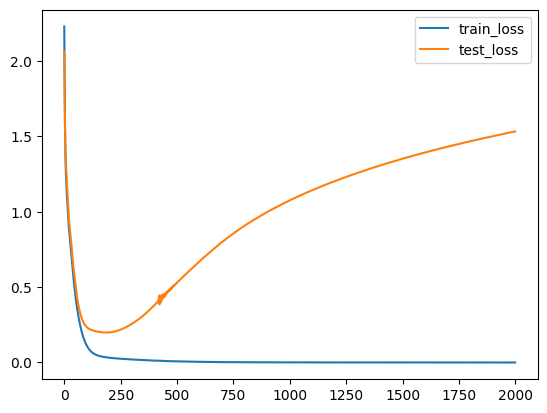

In [20]:
for key, value in history.items():
    plt.plot(range(len(value)), value, label=key)
plt.legend()

In [21]:
from sklearn import metrics

In [22]:
print('train_acc: ', metrics.accuracy_score(y_train, jnp.argmax(rbf_instance(X_train), axis=-1)))
print('test_acc: ', metrics.accuracy_score(y_test, jnp.argmax(rbf_instance(X_test), axis=-1)))

train_acc:  1.0
test_acc:  0.92


In [23]:
mlp_instance = ModelInstance(
    nn.Sequential((
        nn.Dense(10),
        nn.relu,
        nn.Dense(10),
        nn.relu,
        nn.Dense(10),
        nn.relu,
        nn.Dense(3)
    ))
)

mlp_instance.initialize(X_train)

print(f'parameter count: {count_parameters(mlp_instance.parameters_)}')
mlp_instance.attach_optimizer(optax.adam(5e-3))
mlp_instance.compile(optax.softmax_cross_entropy_with_integer_labels, need_vmap=True)


parameter count: 303


In [24]:
iterations = tqdm(range(2000))
history = {'train_loss': [], 'test_loss': []}
for _ in iterations:
    mlp_instance.step(X_train, y_train)
    train_loss = mlp_instance.compute_loss(X_train, y_train)
    test_loss = mlp_instance.compute_loss(X_test, y_test)
    iterations.set_description(f'train_loss: {train_loss: .2e}, test_loss: {test_loss: .2e}')
    history['train_loss'].append(train_loss)
    history['test_loss'].append(test_loss)
    

train_loss:  3.03e-04, test_loss:  4.06e-01: 100%|██████████| 2000/2000 [00:22<00:00, 87.52it/s]


In [25]:
print(min(history['test_loss']))

0.11839588


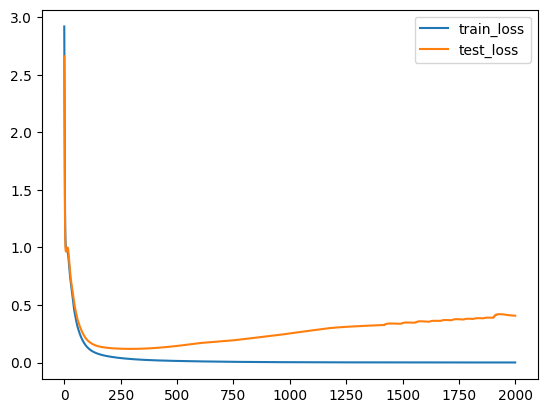

In [26]:
for key, value in history.items():
    plt.plot(range(len(value)), value, label=key)
plt.legend()

In [27]:
print('train_acc: ', metrics.accuracy_score(y_train, jnp.argmax(mlp_instance(X_train), axis=-1)))
print('test_acc: ', metrics.accuracy_score(y_test, jnp.argmax(mlp_instance(X_test), axis=-1)))

train_acc:  1.0
test_acc:  0.96
